# DS 862 — Project 1

1. Dhara Parmanand Khubchandani
2. Sai Naga Sumalya Patnala 
3. Pramod Mantya Raju

# Part I: Dimension Reduction

# Importing the Neccessary Library files

This line of code imports various Python libraries and modules that are used throughout the script

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from prince import MCA
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Data Loading and Preprocessing:

The below segment loads the dataset from a CSV file named 'train.csv' and performs basic preprocessing steps such as dropping irrelevant columns ('Id') and removing rows with missing values.

In [2]:
# Load data set
data = pd.read_csv('train.csv')
data = data.drop('Id', axis = 1)

# Remove columns that have too many missing values
data = data.drop(data.columns[data.isnull().sum() > 30], axis = 1)

# Remove missing values
data.dropna(inplace = True)

# Separate features and target
X = data.drop(columns=['SalePrice'])  # Features
y = data['SalePrice']  # Target

# Feature Engineering:

Here, the dataset is divided into numerical and categorical features, which is a common practice in machine learning pipelines. Numerical features typically contain quantitative data, while categorical features contain qualitative data.

In [3]:
# Separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


# Train-Test Split:

The dataset is split into training and testing sets using train_test_split function. This ensures that the model's performance can be evaluated on unseen data, helping to assess its generalization ability.

In [4]:
# Split numerical and categorical features
X_numerical = X[numerical_cols]
X_categorical = X[categorical_cols]

# Split the numerical features into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical, y, test_size=0.2, random_state=42)

# Split the categorical features into train and test sets
X_train_cat, X_test_cat = train_test_split(X_categorical, test_size=0.2, random_state=42)


# Filtering and Synchronizing Categorical Features:

This segment ensures that the categorical features between the training and testing sets are compatible. It filters the categorical features to keep only those with the same number of unique levels and ensures that categorical features with the same levels have the same classes.

In [5]:
'''
This is the script you can use to check the categorical features between training and testing sets.
You can apply this code after you can done the train/test split, as well as separation of numerical
and categorical features.
'''

# Filter categorical features based on the number of levels
keep = X_train_cat.nunique() == X_test_cat.nunique()
X_train_cat = X_train_cat[X_train_cat.columns[keep]]
X_test_cat = X_test_cat[X_test_cat.columns[keep]]

# Ensure the classes are the same for categorical features with the same levels
keep = []
for i in range(X_train_cat.shape[1]):
    keep.append(all(np.sort(X_train_cat.iloc[:,i].unique()) == np.sort(X_test_cat.iloc[:,i].unique())))
X_train_cat = X_train_cat[X_train_cat.columns[keep]]
X_test_cat = X_test_cat[X_test_cat.columns[keep]]

# Dimensionality Reduction:

Principal Component Analysis (PCA) is applied to reduce the dimensionality of numerical features. It projects the original numerical features into a lower-dimensional space while retaining most of the variance.

Multiple Correspondence Analysis (MCA) is applied to categorical features for dimensionality reduction. It is a method used for categorical data analysis, similar to PCA but adapted for categorical variables.

In [6]:
# Apply PCA on numerical features
pca = PCA()
X_train_pca = pca.fit_transform(X_train_num)
X_test_pca = pca.transform(X_test_num)

# Apply MCA on common categorical features
mca = MCA()
X_train_mca = mca.fit_transform(X_train_cat)
X_test_mca = mca.transform(X_test_cat)

# Regression with Reduced Features:

Ridge regression is performed separately on the reduced numerical features obtained from PCA and the reduced categorical features obtained from MCA. Ridge regression is a linear regression technique that incorporates regularization to prevent overfitting.

In [7]:
# Regression using the reduced features
ridge = Ridge(alpha=0.10)
ridge.fit(X_train_pca, y_train)
y_pred_pca = ridge.predict(X_test_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)

ridge.fit(X_train_mca, y_train)
y_pred_mca = ridge.predict(X_test_mca)
mse_mca = mean_squared_error(y_test, y_pred_mca)

print("MSE using PCA:", mse_pca)
print("MSE using MCA:", mse_mca)

MSE using PCA: 770952426.4747194
MSE using MCA: 3129598717.1076517


The Mean Squared Error (MSE) is a metric used to assess the performance of regression models. It determines the average squared difference between expected and actual values in a dataset. 

The lower the MSE, the better the model performs. In this case, the model employing Principal Component Analysis (PCA) has a considerably lower MSE than the model using Multiple Correspondence Analysis (MCA). This shows that the PCA-based model outperforms the MCA-based model in terms of predictions and data fit. 





# Hyperparameter Tuning with Grid Search:

In the below Segement, the grid search with cross-validation is employed to find the optimal hyperparameters for the Ridge regression model. It systematically searches through a predefined grid of hyperparameters and selects the best combination based on cross-validated performance.

In [8]:
# Define a range of alpha values to tune
alphas = [10.0, 50.0, 150.0]  # You can adjust the range as needed

# Create a dictionary with hyperparameters to tune
param_grid = {'alpha': alphas}

# Initialize the Ridge regression model
ridge = Ridge()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_pca, y_train)  # Assuming X_train_pca is the PCA-transformed numerical features

GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [10.0, 50.0, 150.0]},
             scoring='neg_mean_squared_error')

# Reapplying on Combined Training and Validation Sets:

This step combines the training and validation sets to increase the amount of data available for training. PCA and MCA are reapplied to this combined dataset to ensure consistency in dimensionality reduction.

In [9]:
# Combine training and validation sets
X_train_val_num = pd.concat([X_train_num, X_test_num])
y_train_val = pd.concat([y_train, y_test])
X_train_val_common_cat = pd.concat([X_train_cat, X_test_cat])

# Apply PCA on combined numerical features
X_train_val_pca = pca.fit_transform(X_train_val_num)

# Apply MCA on combined common categorical features
X_train_val_mca = mca.fit_transform(X_train_val_common_cat)

# Perform Grid Search with cross-validation on combined numerical features
grid_search.fit(X_train_val_pca, y_train_val)

GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [10.0, 50.0, 150.0]},
             scoring='neg_mean_squared_error')

# Fitting the Final Model:

The best performing model obtained from grid search is fitted on the combined training and validation sets. This model is expected to have the most optimal hyperparameters.

In [10]:
# Get best hyperparameters and best estimator
best_alpha = grid_search.best_params_['alpha']
best_estimator = grid_search.best_estimator_

# Fit the best estimator on the combined training and validation data
best_estimator.fit(X_train_val_pca, y_train_val)

Ridge(alpha=50.0)

# Final Prediction and Evaluation:

Finally, the model's performance is evaluated on the test set by making predictions using the final model and calculating the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE). These metrics quantify the difference between the predicted and actual values, providing insights into the model's accuracy.

In [11]:
# Apply PCA on test numerical features
X_test_pca_final = pca.transform(X_test_num)

# Apply MCA on test common categorical features
X_test_mca_final = mca.transform(X_test_cat)

# Predict on the test set using the final model
y_pred_final = best_estimator.predict(X_test_pca_final)
mse_final = mean_squared_error(y_test, y_pred_final)
print("MSE using final model on test set:", mse_final)

# Calculate RMSE
rmse_final = np.sqrt(mse_final)
print("RMSE using final model on test set:", rmse_final)

MSE using final model on test set: 700982211.098449
RMSE using final model on test set: 26476.06864884681




MSE represents the average squared difference between the actual and predicted values in the test set. In this case, the MSE is approximately 700,982,211. This means, on average, the squared difference between the actual and predicted values in the test set is around 700,982,211. Lower values of MSE indicate better model performance, so the provided MSE suggests that the final model performs reasonably well in predicting the target variable.


RMSE is the square root of the MSE and provides a measure of the average deviation of the predicted values from the actual values in the same units as the target variable. In this case, the RMSE is approximately 26,476. This means, on average, the difference between the actual and predicted values in the test set is around 26,476 units of the target variable. Lower RMSE values indicate better model performance.

In summary, the model performs reasonably well on the test set, with an MSE of approximately 700,982,211 and an RMSE of approximately 26,476.

# Part II: Clustering Analysis

# Import Necessary Libraries:

In [12]:
import gower
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import normalized_mutual_info_score
import random
import matplotlib.pyplot as plt

**gower:** This library provides functions for computing the Gower distance, which is a measure of dissimilarity between data points with mixed data types.

**kmedoids from pyclustering.cluster:** This library provides an implementation of the K-medoids clustering algorithm, which is suitable for clustering data with arbitrary distance measures.

**random:** This library is used for generating random numbers, which is useful for selecting initial medoids in K-medoids clustering.

**Matplotlib** library and allows you to use the plt namespace to create plots

# Compute the Gower Distance:

This segment concatenates the numerical and categorical features into a single dataset (X_full). The Gower distance matrix is then computed using the concatenated dataset. The rationale behind this is to prepare the data for clustering by computing a distance matrix that accounts for the mixed data types (numerical and categorical).

In [13]:
# Concatenate numerical and categorical features
X_full = pd.concat([X_numerical, X_categorical], axis=1)

# Compute Gower distance matrix
gower_dist = gower.gower_matrix(X_full)

# Apply K-medoids Clustering:

This segment applies the K-medoids clustering algorithm to the dataset with the Gower distance matrix. The algorithm requires specifying the number of clusters and the number of initial medoids. Random initial medoids are selected to start the clustering process. The rationale behind using K-medoids clustering is to partition the dataset into clusters based on the dissimilarity calculated by the Gower distance, with medoids representing the most central points in each cluster.

In [14]:
# Define the number of clusters
num_clusters = 3  # You may choose any number of clusters

# Select random initial medoids
num_medoids = 3  # Specify the number of initial medoids
initial_index_medoids = random.sample(range(len(gower_dist)), num_medoids)

# Initialize K-medoids algorithm with random initial medoids
kmedoids_instance = kmedoids(gower_dist, initial_index_medoids=initial_index_medoids, data_type='distance_matrix')

# Run K-medoids clustering
kmedoids_instance.process()

# Get cluster labels and medoids
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

# Print cluster labels and medoids
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1}:")
    print("Indices of data points in the cluster:", cluster)
    print("Medoid:", medoids[i])

Cluster 1:
Indices of data points in the cluster: [2, 4, 6, 13, 18, 22, 25, 27, 32, 34, 36, 45, 47, 53, 60, 62, 64, 67, 70, 81, 82, 89, 96, 100, 103, 109, 123, 133, 135, 137, 138, 141, 143, 148, 151, 162, 166, 169, 174, 178, 186, 189, 192, 196, 199, 200, 203, 211, 213, 216, 219, 220, 224, 229, 235, 237, 239, 250, 256, 275, 277, 280, 281, 282, 283, 301, 304, 308, 325, 331, 332, 335, 336, 337, 342, 346, 349, 350, 354, 355, 361, 368, 375, 377, 380, 384, 387, 398, 399, 400, 404, 411, 419, 420, 425, 427, 428, 439, 442, 445, 450, 456, 464, 467, 469, 471, 472, 473, 475, 477, 479, 480, 482, 495, 497, 506, 510, 514, 528, 537, 538, 540, 550, 557, 565, 575, 578, 579, 583, 591, 593, 595, 596, 602, 604, 608, 610, 616, 629, 637, 638, 642, 651, 653, 658, 661, 664, 670, 674, 675, 679, 680, 685, 686, 687, 692, 696, 697, 701, 703, 704, 709, 715, 717, 718, 721, 723, 724, 727, 728, 739, 741, 745, 749, 762, 765, 771, 772, 773, 777, 779, 780, 787, 790, 802, 808, 812, 814, 816, 821, 822, 824, 829, 835, 847, 

**Interpretetion**

Each data point index represents an individual record or observation in the dataset. The medoid of each cluster is the data point that is most centrally located within the cluster according to a specified distance metric.

This information provides a breakdown of how the data points are grouped into clusters, aiding in understanding the structure and characteristics of the dataset through the lens of the clustering algorithm.

# Create an Array of Cluster Memberships:

This segment creates an array (cluster_memberships) where each element corresponds to a data point's cluster membership. The rationale is to assign each data point to its respective cluster based on the clustering result obtained from K-medoids.

In [15]:
cluster_memberships = np.zeros(X_full.shape[0])
for cluster_idx, cluster in enumerate(clusters):
    cluster_memberships[cluster] = cluster_idx

# Bin the Response Variable (SalePrice):

This segment bins the response variable (SalePrice) into the same number of categories as clusters. Binning the response variable allows for comparison with cluster labels, facilitating the evaluation of clustering performance using metrics such as normalized mutual information (NMI).

In [16]:
num_bins = num_clusters  # Bin into the same number of categories as clusters
y_binned = pd.qcut(y, q=num_bins, labels=False, duplicates='drop')

# Compute Normalized Mutual Information (NMI):

This segment computes the normalized mutual information (NMI) between the clustering result and ground truth (binned SalePrice).

In [17]:
nmi_score = normalized_mutual_info_score(y_binned, cluster_memberships)
print("Normalized Mutual Information (NMI) between clustering result and ground truth:", nmi_score)

Normalized Mutual Information (NMI) between clustering result and ground truth: 0.28863032518077514


NMI between clustering result and ground truth: 0.2886
NMI measures the similarity between two clusterings. In this context, it quantifies how well the clusters obtained from the clustering algorithm align with the actual (ground truth) labels.

A value closer to 1 indicates strong agreement between the clustering result and the ground truth, while a value close to 0 suggests no agreement beyond chance. In our case, an NMI score of approximately 0.2886 suggests some level of agreement between the clustering result and the ground truth labels, although the agreement might not be very strong.

# Plot the Clustered Data Points:

This segment plots the clustered data points along with the medoids for visualization of the K-medoids clustering result.

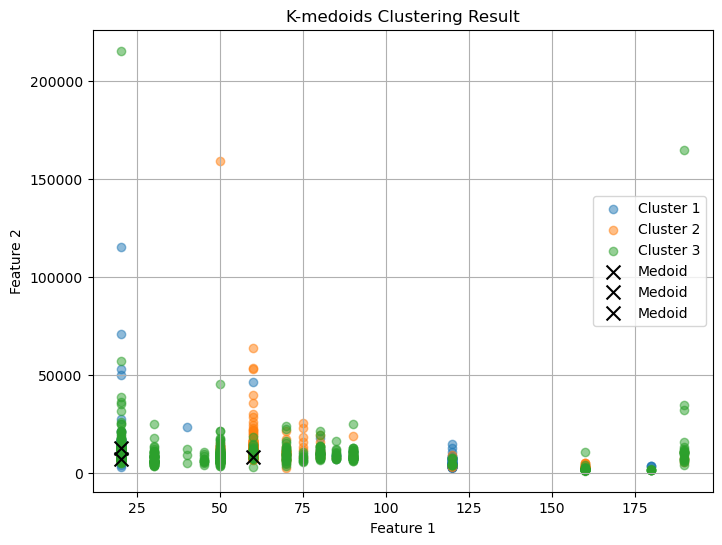

In [18]:
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(clusters):
    plt.scatter(X_full.iloc[cluster, 0], X_full.iloc[cluster, 1], label=f'Cluster {i + 1}', alpha=0.5)

# Plot the medoids
for medoid in medoids:
    plt.scatter(X_full.iloc[medoid, 0], X_full.iloc[medoid, 1], marker='x', s=100, c='black', label='Medoid')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-medoids Clustering Result')
plt.legend()
plt.grid(True)
plt.show()

**Interpretetion of the Plot**

The scatter plot provides a visual representation of the clustering results, revealing the structure and characteristics of the data points within each cluster. Analysis of the plot suggests clear differentiation between clusters, with each cluster exhibiting its own unique pattern and distribution of data points around the respective medoids.